In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle 
import torch
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import json
import re

In [4]:
import argparse
import os
import sys
sys.path.append('/u/dbeaglehole/mech_interp/neural_controllers/')

NEURAL_CONTROLLERS_DIR = '/u/dbeaglehole/mech_interp/neural_controllers'
from neural_controllers import NeuralController
from utils import load_model

### Llama

In [9]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the range of seeds and methods
seeds = np.arange(5)
methods = ['rfm', 'linear', 'logistic']
model_name = 'llama_3_8b_it'
# model_name = 'llama_3.3_70b_4bit_it'
# Initialize dictionaries to store results
results = {
    'val': {method: {} for method in methods},
    'test': {method: {} for method in methods},
    'trivial_metrics_val': [],
    'trivial_metrics_test': [],
    'selected_test_metrics': {method: [] for method in methods}
}

# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_wild_results/multiclass_{model_name}_{method}_seed_{s}_val_metrics.pkl'
        path_test = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_wild_results/multiclass_{model_name}_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"File not found: {path_val}")
            if not os.path.exists(path_test):
                print(f"File not found: {path_test}")
            continue

            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Collect per-layer metrics
        for key in layers_val:
            if key not in results['val'][method]:
                results['val'][method][key] = []
            results['val'][method][key].append(val_results[key])
        
        for key in layers_test:
            if key not in results['test'][method]:
                results['test'][method][key] = []
            results['test'][method][key].append(test_results[key])
        
        # Identify best layer and store test metrics
        if layers_val:
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            results['selected_test_metrics'][method].append(best_test_metrics)

# Calculate and store averaged metrics
print("Best single layer")
averaged_metrics = defaultdict(lambda: defaultdict(dict))
for method in methods:
    test_metrics_list = results['selected_test_metrics'][method]
    if test_metrics_list:
        print(f"\n{method.upper()}:")
        metrics_dict = {}
        # Calculate mean and std for each metric
        for metric in test_metrics_list[0].keys():
            values = [metrics[metric] for metrics in test_metrics_list]
            mean_val = np.mean(values)
            std_val = np.std(values)
            metrics_dict[metric] = {'mean': mean_val, 'std': std_val}
            print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")
            # Store in averaged_metrics for potential further analysis
            averaged_metrics[method][metric] = {
                'mean': mean_val,
                'std': std_val
            }

Best single layer

RFM:
acc: 70.0000 ± 4.3818
precision: 0.6797 ± 0.0267
recall: 0.6991 ± 0.0202
f1: 0.6675 ± 0.0300
auc: 0.9076 ± 0.0195
mse: 0.0792 ± 0.0067

LINEAR:
acc: 68.8000 ± 6.1449
precision: 0.6536 ± 0.0737
recall: 0.6859 ± 0.0556
f1: 0.6541 ± 0.0634
auc: 0.8994 ± 0.0113
mse: 0.0806 ± 0.0037

LOGISTIC:
acc: 68.4000 ± 4.9639
precision: 0.6717 ± 0.0534
recall: 0.6956 ± 0.0470
f1: 0.6634 ± 0.0462
auc: 0.8812 ± 0.0052
mse: 2.6462 ± 0.4264


In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the methods
methods = ['rfm','linear', 'logistic', 'rfm_linear', 'linear_rfm']
# Initialize dictionary to store results
results = {
    'aggs_over_seeds': {method: [] for method in methods},
    'trivial_accs': []
}

# Load data for each method
for method in methods:        
    for s in seeds:
        path = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_wild_results/multiclass_{model_name}_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            current_results = pickle.load(f)
            
        # Store linear_agg results
        if 'aggregation' in current_results:
            results['aggs_over_seeds'][method].append(current_results['aggregation'])

# Initialize dictionary for overall averages
overall_averages = defaultdict(lambda: defaultdict(dict))

# Print results
print("\nAccuracy Metrics (Aggregated Over Seeds):")

for method in methods:
    print(f"\n{method.upper()}:")
    aggs = results['aggs_over_seeds'][method]
    
    if aggs:
        # Get all metric keys from the first result
        metric_keys = aggs[0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")
            
            # Store for overall averages
            if method not in overall_averages[metric]:
                overall_averages[metric][method] = mean

File not found: /u/dbeaglehole/mech_interp/neural_controllers/results/halu_eval_wild_results/multiclass_llama_3.3_70b_4bit_it_linear_rfm_seed_0_test_metrics.pkl
File not found: /u/dbeaglehole/mech_interp/neural_controllers/results/halu_eval_wild_results/multiclass_llama_3.3_70b_4bit_it_linear_rfm_seed_1_test_metrics.pkl
File not found: /u/dbeaglehole/mech_interp/neural_controllers/results/halu_eval_wild_results/multiclass_llama_3.3_70b_4bit_it_linear_rfm_seed_2_test_metrics.pkl
File not found: /u/dbeaglehole/mech_interp/neural_controllers/results/halu_eval_wild_results/multiclass_llama_3.3_70b_4bit_it_linear_rfm_seed_3_test_metrics.pkl
File not found: /u/dbeaglehole/mech_interp/neural_controllers/results/halu_eval_wild_results/multiclass_llama_3.3_70b_4bit_it_linear_rfm_seed_4_test_metrics.pkl

Accuracy Metrics (Aggregated Over Seeds):

RFM:
acc: 68.0000 ± 3.3466
precision: 0.6732 ± 0.0364
recall: 0.6947 ± 0.0377
f1: 0.6608 ± 0.0315
auc: 0.9057 ± 0.0234
mse: 0.0795 ± 0.0079

LINEAR:
ac

layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, 'linear_agg'])
layers [-31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]
layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, 'linear_agg'])
layers [-41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


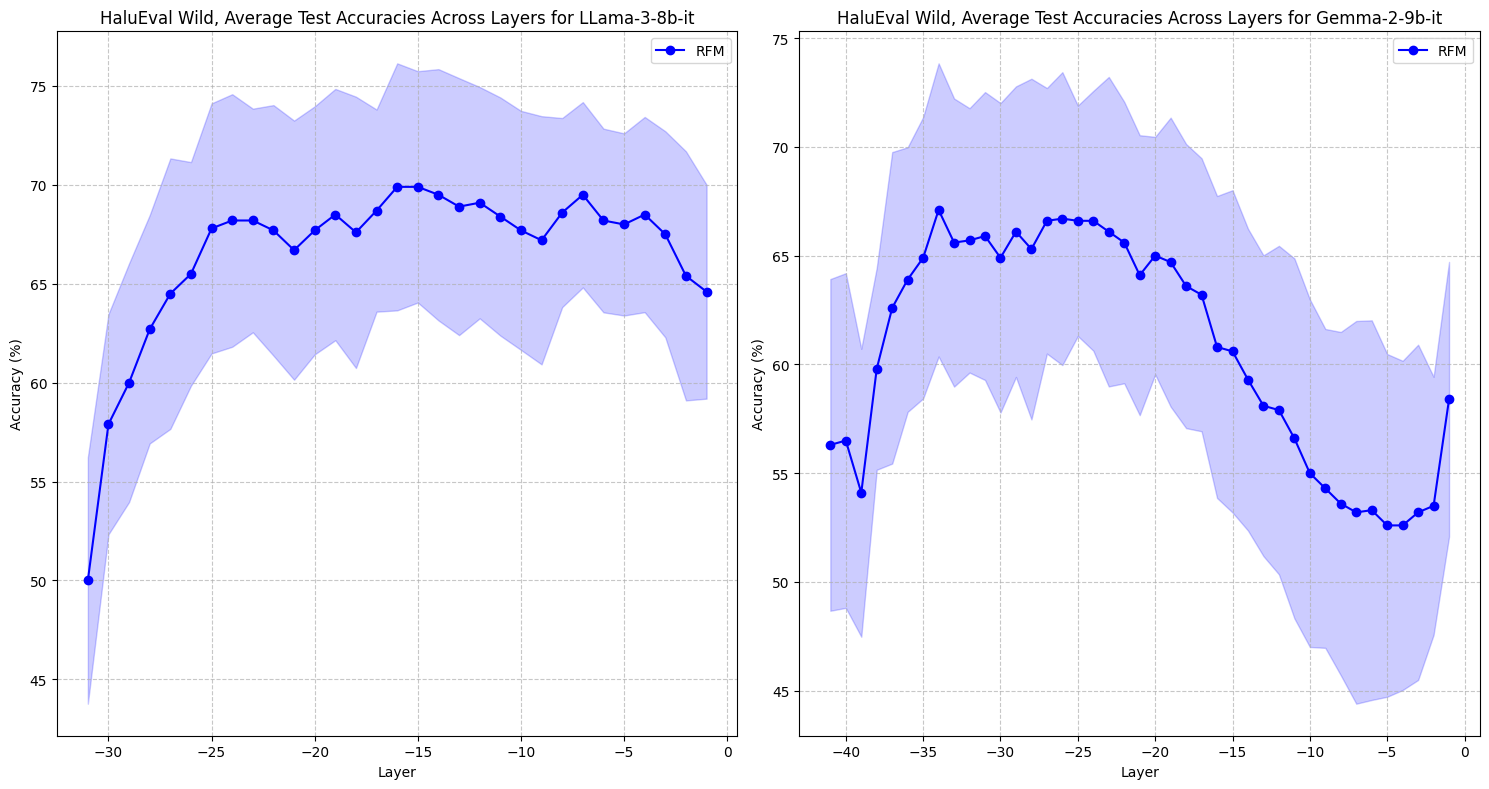

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the range of seeds
seeds = np.arange(20)
methods = ['rfm']#, 'logistic']
models = ['llama_3_8b', 'gemma_2_9b']

# Initialize dictionaries to store results
all_results = {}

for model in models:
    all_results[model] = {
        'test': {method: {} for method in methods}
    }

    # Load data for each method
    for method in methods:
        # Process each seed
        for s in seeds:
            # Path for test metrics
            path_test = f'/u/dbeaglehole/mech_interp/neural_controllers/quantitative_comparisons/halu_eval_wild_results/multiclass_{model}_it_{method}_seed_{s}_test_metrics.pkl'
            
            # Check if file exists
            if not os.path.exists(path_test):
                print(f"File not found: {path_test}")
                continue
                
            # Load test results
            with open(path_test, 'rb') as f:
                test_results = pickle.load(f)
            
            # Get layer keys (excluding non-dict entries)
            layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
            
            # Collect per-layer metrics
            for key in layers_test:
                if key not in all_results[model]['test'][method]:
                    all_results[model]['test'][method][key] = []
                all_results[model]['test'][method][key].append(test_results[key]['acc'])

# Calculate average accuracies per layer
avg_results = {}
for model in models:
    avg_results[model] = {}
    for method in methods:
        avg_results[model][method] = {}
        for layer, accs in all_results[model]['test'][method].items():
            if accs:  # Check if we have data for this layer
                avg_results[model][method][layer] = {
                    'mean': np.mean(accs),
                    'std': np.std(accs)
                }


# Plot the results
plt.figure(figsize=(15, 8))

# Define colors and alpha values for shading
colors = {'rfm': 'blue', 'logistic': 'red'}
alpha_fill = 0.2  # Alpha transparency for the shaded region

for i, model in enumerate(models):
    plt.subplot(1, 2, i+1)
    
    for method in methods:
        layer_data = avg_results[model][method]
        print("layer_data.keys()", layer_data.keys())
        if layer_data:
            # Sort layers by their numerical value
            layers = sorted([int(layer) for layer in layer_data.keys() if isinstance(layer, int)])
            print("layers", layers)
            
            # Extract mean and std for plotting
            means = [layer_data[layer]['mean'] for layer in layers if layer in layer_data]
            stds = [layer_data[layer]['std'] for layer in layers if layer in layer_data]
            
            # Plot the mean line
            plt.plot(layers, means, label=method.upper(), marker='o', color=colors[method])
            
            # Add shaded error region
            plt.fill_between(
                layers, 
                [m - s for m, s in zip(means, stds)],  # lower bound
                [m + s for m, s in zip(means, stds)],  # upper bound
                color=colors[method], 
                alpha=alpha_fill
            )
    
    plt.title(f'HaluEval Wild, Average Test Accuracies Across Layers for {model.replace(model[0], model[0].upper()).replace("_", "-")}-it')
    plt.xlabel('Layer')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

plt.savefig('he_wild_test_accuracies_across_layers.pdf', format='pdf')
plt.show()

## Gemma 2 9b

In [11]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the range of seeds and methods
seeds = np.arange(20)
methods = ['rfm', 'linear', 'logistic']

# Initialize dictionaries to store results
results = {
    'val': {method: {} for method in methods},
    'test': {method: {} for method in methods},
    'trivial_metrics_val': [],
    'trivial_metrics_test': [],
    'selected_test_metrics': {method: [] for method in methods}
}

# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'../halu_eval_wild_results/multiclass_gemma_2_9b_it_{method}_seed_{s}_val_metrics.pkl'
        path_test = f'../halu_eval_wild_results/multiclass_gemma_2_9b_it_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if files exist
        if not os.path.exists(path_val) or not os.path.exists(path_test):
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Collect per-layer metrics
        for key in layers_val:
            if key not in results['val'][method]:
                results['val'][method][key] = []
            results['val'][method][key].append(val_results[key])
        
        for key in layers_test:
            if key not in results['test'][method]:
                results['test'][method][key] = []
            results['test'][method][key].append(test_results[key])
        
        # Identify best layer and store test metrics
        if layers_val:
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            results['selected_test_metrics'][method].append(best_test_metrics)

# Calculate and store averaged metrics
averaged_metrics = defaultdict(lambda: defaultdict(dict))
for method in methods:
    test_metrics_list = results['selected_test_metrics'][method]
    if test_metrics_list:
        print(f"\n{method.upper()}:")
        metrics_dict = {}
        # Calculate mean and std for each metric
        for metric in test_metrics_list[0].keys():
            values = [metrics[metric] for metrics in test_metrics_list]
            mean_val = np.mean(values)
            std_val = np.std(values)
            metrics_dict[metric] = {'mean': mean_val, 'std': std_val}
            print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")
            # Store in averaged_metrics for potential further analysis
            averaged_metrics[method][metric] = {
                'mean': mean_val,
                'std': std_val
            }


RFM:
acc: 66.4000 ± 6.6813
precision: 0.6535 ± 0.0828
recall: 0.6649 ± 0.0638
f1: 0.6247 ± 0.0644

LINEAR:
acc: 65.4000 ± 6.2000
precision: 0.6441 ± 0.0827
recall: 0.6501 ± 0.0558
f1: 0.6121 ± 0.0621

LOGISTIC:
acc: 64.9000 ± 5.8472
precision: 0.6485 ± 0.0593
recall: 0.6434 ± 0.0629
f1: 0.6313 ± 0.0577


In [10]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the methods
methods = ['rfm', 'rfm_linear', 'linear_rfm', 'linear', 'logistic']

# Initialize dictionary to store results
results = {
    'aggs_over_seeds': {method: [] for method in methods},
    'trivial_accs': []
}

# Load data for each method
for method in methods:        
    for s in seeds:
        path = f'../halu_eval_wild_results/multiclass_gemma_2_9b_it_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            current_results = pickle.load(f)
            
        # Store linear_agg results
        if 'linear_agg' in current_results:
            results['aggs_over_seeds'][method].append(current_results['linear_agg'])

# Initialize dictionary for overall averages
overall_averages = defaultdict(lambda: defaultdict(dict))

# Print results
print("\nAccuracy Metrics (Aggregated Over Seeds):")

for method in methods:
    print(f"\n{method.upper()}:")
    aggs = results['aggs_over_seeds'][method]
    
    if aggs:
        # Get all metric keys from the first result
        metric_keys = aggs[0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")
            
            # Store for overall averages
            if method not in overall_averages[metric]:
                overall_averages[metric][method] = mean


Accuracy Metrics (Aggregated Over Seeds):

RFM:
acc: 58.5000 ± 7.2904
precision: 0.5707 ± 0.0736
recall: 0.5800 ± 0.0678
f1: 0.5590 ± 0.0670

RFM_LINEAR:
acc: 65.9000 ± 6.8549
precision: 0.6520 ± 0.0692
recall: 0.6594 ± 0.0624
f1: 0.6357 ± 0.0607

LINEAR_RFM:
acc: 64.0000 ± 5.9666
precision: 0.6421 ± 0.0621
recall: 0.6339 ± 0.0634
f1: 0.6199 ± 0.0589

LINEAR:
acc: 55.8000 ± 6.0959
precision: 0.5575 ± 0.0575
recall: 0.5555 ± 0.0604
f1: 0.5446 ± 0.0582

LOGISTIC:
acc: 59.4000 ± 5.9025
precision: 0.6001 ± 0.0661
recall: 0.5890 ± 0.0648
f1: 0.5805 ± 0.0624


## Llama judge

In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Initialize dictionary to store all results
all_results = []

seeds = np.arange(20)  # Seeds to evaluate

# Process results for all seeds
for s in seeds:
    path = f'../halu_eval_wild_results/multiclass_llama_gpt-4o_seed_{s}_metrics.pkl'
    
    # Check if file exists
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue
        
    with open(path, 'rb') as f:
        results = pickle.load(f)
        all_results.append(results)

# Calculate and print metrics
if all_results:
    # Get all metric keys from the first result
    metric_keys = [k for k in all_results[0].keys()]
    
    print("\nOverall metrics:")
    for metric in metric_keys:
        values = [result[metric] for result in all_results if isinstance(result[metric], (int, float))]
        if values:
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")


Overall metrics:
acc: 39.9000 ± 6.0819
precision: 0.5120 ± 0.0863
recall: 0.3888 ± 0.0647
f1: 0.3732 ± 0.0674


## Gemma judge

In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Initialize dictionary to store all results
all_results = []

seeds = np.arange(20)  # Seeds to evaluate

# Process results for all seeds
for s in seeds:
    path = f'../halu_eval_wild_results/multiclass_gemma_gpt-4o_seed_{s}_metrics.pkl'
    
    # Check if file exists
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue
        
    with open(path, 'rb') as f:
        results = pickle.load(f)
        all_results.append(results)

# Calculate and print metrics
if all_results:
    # Get all metric keys from the first result
    metric_keys = [k for k in all_results[0].keys()]
    
    print("\nOverall metrics:")
    for metric in metric_keys:
        values = [result[metric] for result in all_results if isinstance(result[metric], (int, float))]
        if values:
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")


Overall metrics:
acc: 43.5000 ± 6.5992
precision: 0.4884 ± 0.1063
recall: 0.4267 ± 0.0638
f1: 0.4025 ± 0.0617


## GPT-4o judge

In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Initialize dictionary to store all results
all_results = []

seeds = np.arange(20)  # Seeds to evaluate

# Process results for all seeds
for s in seeds:
    path = f'../halu_eval_wild_results/multiclass_openai_gpt-4o_seed_{s}_metrics.pkl'
    
    # Check if file exists
    if not os.path.exists(path):
        print(f"File not found: {path}")
        continue
        
    with open(path, 'rb') as f:
        results = pickle.load(f)
        all_results.append(results)

# Calculate and print metrics
if all_results:
    # Get all metric keys from the first result
    metric_keys = [k for k in all_results[0].keys()]
    
    print("\nOverall metrics:")
    for metric in metric_keys:
        values = [result[metric] for result in all_results if isinstance(result[metric], (int, float))]
        if values:
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")


Overall metrics:
acc: 46.2000 ± 4.9356
precision: 0.4170 ± 0.0504
recall: 0.4666 ± 0.0434
f1: 0.4042 ± 0.0441
